<a href="https://colab.research.google.com/github/lmcanavals/machine_learning/blob/main/0202_Performance_metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance metrics

#### Imports and important notes

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from sklearn.linear_model import LogisticRegression

To see warnings change `ignore` to `default`

In [12]:
import warnings
warnings.filterwarnings('ignore')

#### Loading data

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

In [2]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist.data, mnist.target
print(X.shape, y.shape)

(70000, 784) (70000,)


#### Exploring data

<ipython-input-26-3e1f38cd530b>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(5, 10, i+1)


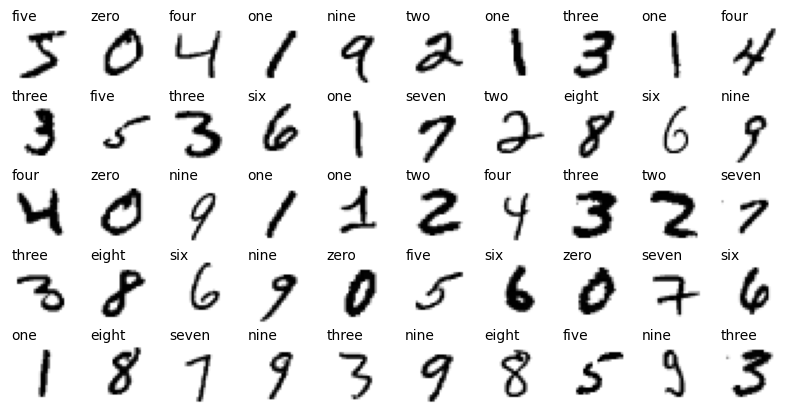

In [ ]:
plt.subplots(figsize=(10, 5))
labels = ["zero", "one", "two", "three", "four",
          "five", "six", "seven", "eight", "nine"]
for i in range(50):
    ax = plt.subplot(5, 10, i+1)
    idx = i #random.randint(0, 60000)
    ax.axis('off')
    ax.imshow(X[idx].reshape((28, 28)), cmap='gray_r')
    ax.text(0, 0, labels[int(y[idx])])
plt.show()

#### Partitioning Data

In [5]:
X_train, y_train = X[:60000], y[:60000]
X_val, y_val =  X[60000:], y[60000:]

In [6]:
y_train_5 = (y_train == '5')
y_val_5 = (y_val == '5')

#### Logistic regresion classifier (lrc) for testing

In [13]:
lrc = LogisticRegression(random_state=42)
lrc.fit(X_train, y_train_5)

LogisticRegression(random_state=42)

#### Checking training accuracy

In [14]:
y_train_5_hat = lrc.predict(X_train)
acc_train = np.sum((y_train_5 == y_train_5_hat)) / 60000
print("Accuracy:", acc_train)
print("Bias:", 1 - acc_train)

Accuracy: 0.9778166666666667
Bias: 0.022183333333333333


now valitadion accuracy

In [15]:
y_val_5_hat = lrc.predict(X_val)
acc_val = np.sum((y_val_5 == y_val_5_hat)) / 10000
print("Accuracy:", acc_val)
print(f"Variance: {(acc_train - acc_val)*100:5f}")

Accuracy: 0.9779
Variance: -0.008333


Variance indicates a negligible overfitting

## Cross Validation

In [8]:
from sklearn.model_selection import cross_val_score

In [16]:
cross_val_score(lrc, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.97525, 0.9732 , 0.9732 ])

## Confusion Matrix

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

In [18]:
y_train_pred = cross_val_predict(lrc, X_train, y_train_5, cv=3)

In [38]:
def confMatrix(cm):
    print(cm)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)
    ax.set_xlabel("Predicted labels")
    ax.set_ylabel("True labels")
    ax.xaxis.set_ticklabels(["Not five", "Five"])
    ax.yaxis.set_ticklabels(["Not five", "Five"])

[[54038   541]
 [ 1026  4395]]


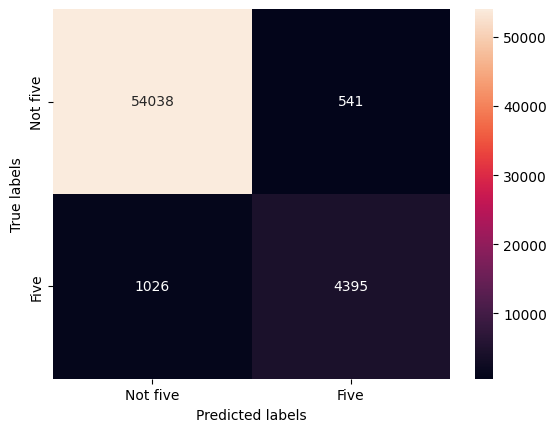

In [39]:
cm = confusion_matrix(y_train_5, y_train_pred)
confMatrix(cm)

In [37]:
print(len(y_train_5[y_train_5 & (y_train_pred==False)]))

1026


[[9034   74]
 [ 147  745]]


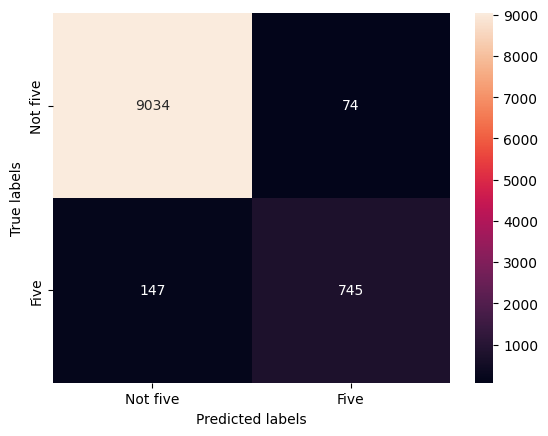

In [41]:
y_val_pred = lrc.predict(X_val)
cm_val = confusion_matrix(y_val_5, y_val_pred)
confMatrix(cm_val)

## Precision and Recall

#### by hand from the confusion matrix

In [ ]:
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
precision

0.8903970826580226

In [ ]:
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
recall

0.8107360265633647

#### Using sklearn

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
precision_score(y_train_5, y_train_pred)

0.8903970826580226

In [ ]:
recall_score(y_train_5, y_train_pred)

0.8107360265633647

## F1-score

In [42]:
from sklearn.metrics import f1_score

In [43]:
f1_score(y_train_5, y_train_pred)

0.8487013613980882

## Precision and Recall trade-off

In [51]:
y_scores = lrc.decision_function(X_train[:2])
y_scores > 0

array([ True, False])

In [52]:
y_scores = cross_val_predict(lrc, X_train, y_train_5, cv=3,
                             method="decision_function")

In [53]:
from sklearn.metrics import precision_recall_curve

In [58]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [63]:
def plot_precision_recall_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g--', label="Recall", linewidth=2)
    plt.legend()
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    #plt.axis([-50000, 50000, 0, 1])

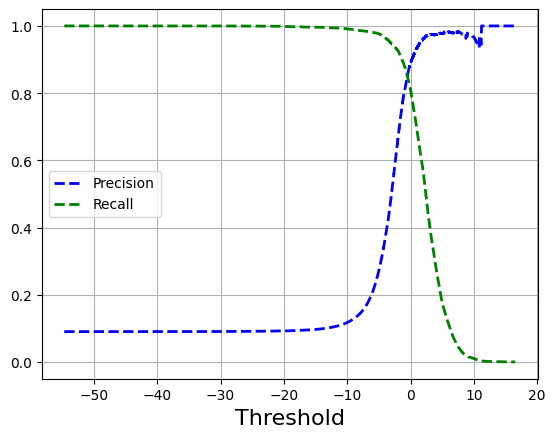

In [64]:
recall_90_precision = recalls[np.argmax(precisions >= 0.9)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

plot_precision_recall_threshold(precisions, recalls, thresholds)

## ROC Curve

In [66]:
from sklearn.metrics import roc_curve

In [68]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [69]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False positive rate (fall-out)", fontsize=16)
    plt.xlabel("True positive rate (Recall)", fontsize=16)
    plt.grid(True)

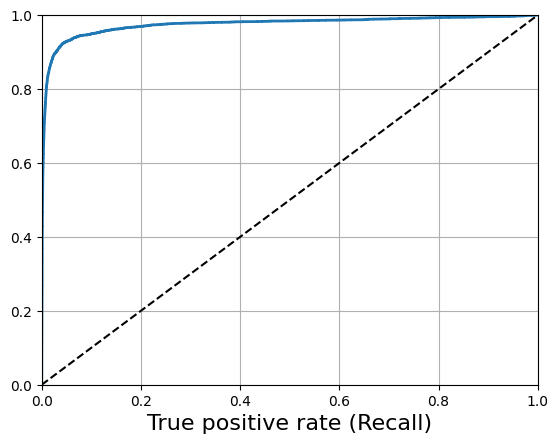

In [70]:
plot_roc_curve(fpr, tpr)

In [71]:
from sklearn.metrics import roc_auc_score

In [73]:
roc_auc_score(y_train_5, y_scores)

0.9748673009805543